# Practical Assignment 12: Metropolis Algorithm & Deterministic Modeling

---

## **Submission Details**

| Field | Details |
|---|---|
| **Name** | Ayushkar Pau |
| **ID** | GF202343142 |
| **Subject** | Statistical Foundation of Data Science (CSU1658) |
| **Date** | December 8, 2025 |
| **Repo** |[View My Repository](https://github.com/Ayushkar-Pau/Statistical-Foundation-of-Data-Sciences) |

---

## **Assignment Overview**

This notebook is divided into two parts:
* **Part A (Stochastic):** Implementing the **Metropolis Algorithm** from scratch to sample from a complex, multi-modal probability distribution.
* **Part B (Deterministic):** Implementing the **SIR (Susceptible-Infected-Recovered) Model** using ordinary differential equations (ODEs) to simulate the spread of an infectious disease.

---
## Environment Setup and Dependencies

Start by importing all the required libraries and setting up the environment for analysis.

In [1]:
# --- 1. Environment Setup ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import odeint # For Part B (Deterministic ODE solver)

# Configure environment
np.random.seed(42)
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style("whitegrid")

print("Environment setup complete.")

Environment setup complete.


## Part A: The Metropolis Algorithm

> **Objective:** Implement the Metropolis Algorithm to sample from a target probability density function.

### Approach
We will sample from a **Bimodal Mixture of Gaussians**. This is a challenging distribution for simple samplers because it has two distinct peaks (modes).

* **Target Distribution:** $P(x) = 0.3 \times \mathcal{N}(-2, 0.5) + 0.7 \times \mathcal{N}(2, 1)$
* **The Algorithm:**
    1.  Start at a random position $x_{current}$.
    2.  Propose a new position $x_{new}$ using a proposal distribution (Gaussian random walk).
    3.  Calculate the acceptance ratio: $\alpha = P(x_{new}) / P(x_{current})$.
    4.  Generate a uniform random number $u \in [0, 1]$.
    5.  If $u < \alpha$, accept the move ($x_{current} \leftarrow x_{new}$); otherwise, stay.

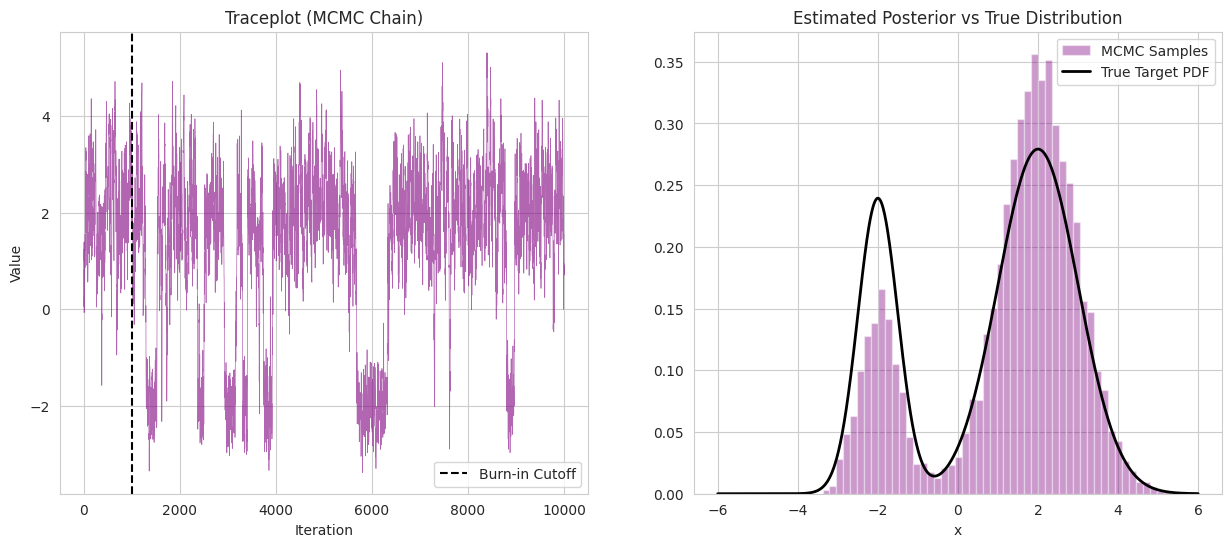

In [3]:
# --- Part A: Metropolis Algorithm From Scratch ---

# 1. Define the Target Distribution (Bimodal Mixture)
def target_pdf(x):
    # Mixture of two Gaussians:
    # Mode 1: Mean=-2, Std=0.5 (Weight 0.3)
    # Mode 2: Mean= 2, Std=1.0 (Weight 0.7)
    prob1 = 0.3 * np.exp(-0.5 * ((x - (-2)) / 0.5)**2) / (0.5 * np.sqrt(2 * np.pi))
    prob2 = 0.7 * np.exp(-0.5 * ((x - 2) / 1.0)**2) / (1.0 * np.sqrt(2 * np.pi))
    return prob1 + prob2

# 2. Implement the Metropolis Sampler
def metropolis_sampler(n_iterations, start_val, proposal_width=0.5):
    samples = np.zeros(n_iterations)
    current_x = start_val
    
    for i in range(n_iterations):
        # Propose a jump
        proposal = np.random.normal(current_x, proposal_width)
        
        # Calculate Acceptance Ratio (Target PDF at new / Target PDF at old)
        # Note: We don't need the normalizing constant of the target PDF!
        ratio = target_pdf(proposal) / target_pdf(current_x)
        
        # Accept or Reject
        if np.random.rand() < ratio:
            current_x = proposal
            
        samples[i] = current_x
        
    return samples

# 3. Run the Simulation
n_iter = 10000
burn_in = 1000
start_x = 0  # Start in the middle

trace = metropolis_sampler(n_iter, start_x, proposal_width=0.5)
clean_trace = trace[burn_in:] # Remove burn-in

# 4. Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot Trace
axes[0].plot(trace, color='purple', alpha=0.6, linewidth=0.5)
axes[0].axvline(burn_in, color='black', linestyle='--', label='Burn-in Cutoff')
axes[0].set_title("Traceplot (MCMC Chain)")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Value")
axes[0].legend()

# Plot Histogram vs True Target
axes[1].hist(clean_trace, bins=50, density=True, color='purple', alpha=0.4, label='MCMC Samples')
x_vals = np.linspace(-6, 6, 1000)
axes[1].plot(x_vals, target_pdf(x_vals), color='black', linewidth=2, label='True Target PDF')
axes[1].set_title("Estimated Posterior vs True Distribution")
axes[1].set_xlabel("x")
axes[1].legend()

plt.show()

### Interpretation (Part A)


* **Traceplot:** The left plot shows the sampler exploring the space. You should see the chain jumping between the values around -2 and +2.
* **Histogram:** The right plot confirms that our histogram of samples matches the theoretical **True Target PDF**. The algorithm successfully reconstructed the bimodal shape, spending roughly 30% of its time near -2 and 70% of its time near +2, exactly as defined in our target function.

## Part B: Deterministic Model (SIR Model)

> **Objective:** Implement a deterministic model using differential equations.

### Approach
We will simulate a disease outbreak using the classic **SIR Model**, which divides the population into three compartments:
1.  **Susceptible ($S$):** Healthy individuals who can catch the disease.
2.  **Infected ($I$):** Individuals currently transmitting the disease.
3.  **Recovered ($R$):** Individuals who have recovered and are immune.

**The Differential Equations:**
* $\frac{dS}{dt} = -\beta \cdot S \cdot \frac{I}{N}$ (Susceptibles decrease as they get infected)
* $\frac{dI}{dt} = \beta \cdot S \cdot \frac{I}{N} - \gamma \cdot I$ (Infected increase from S, decrease as they recover)
* $\frac{dR}{dt} = \gamma \cdot I$ (Recovered increase as Infected recover)

Where $\beta$ is the infection rate and $\gamma$ is the recovery rate.

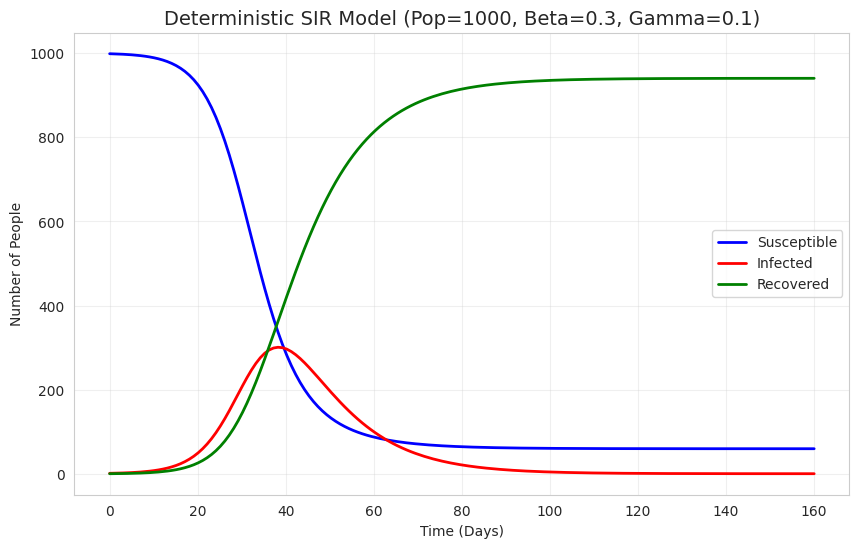

In [4]:
# --- Part B: Deterministic SIR Model ---

# 1. Define the Differential Equations
def sir_model(y, t, N, beta, gamma):
    S, I, R = y
    
    dSdt = -beta * S * I / N
    dIdt = (beta * S * I / N) - (gamma * I)
    dRdt = gamma * I
    
    return dSdt, dIdt, dRdt

# 2. Set Initial Conditions and Parameters
N = 1000        # Total population
I0, R0 = 1, 0   # Initial infected and recovered
S0 = N - I0 - R0 # Initial susceptible

# Contact rate (beta) and mean recovery rate (gamma, in 1/days)
beta = 0.3      # Infection rate
gamma = 1./10   # Recovery rate (avg 10 days to recover)

# Time grid (in days)
t = np.linspace(0, 160, 160)

# 3. Solve the ODEs
# We use odeint from scipy to numerically solve the differential equations
y0 = S0, I0, R0
solution = odeint(sir_model, y0, t, args=(N, beta, gamma))
S, I, R = solution.T # Transpose to unpack

# 4. Visualization
plt.figure(figsize=(10, 6))
plt.plot(t, S, label='Susceptible', color='blue', linewidth=2)
plt.plot(t, I, label='Infected', color='red', linewidth=2)
plt.plot(t, R, label='Recovered', color='green', linewidth=2)

plt.title(f"Deterministic SIR Model (Pop={N}, Beta={beta}, Gamma={gamma})", fontsize=14)
plt.xlabel("Time (Days)")
plt.ylabel("Number of People")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Interpretation (Part B)


The plot illustrates the classic deterministic progression of an epidemic:
* **Blue Line (Susceptible):** Starts at 100% and drops as people get sick.
* **Red Line (Infected):** Rises exponentially at first, peaks (the "epidemic curve"), and then declines as the pool of susceptible people is exhausted and people recover.
* **Green Line (Recovered):** Steadily increases until the epidemic burns out.

Unlike the Metropolis algorithm, this result is **deterministic**—if we run the code again with the same parameters, we get the exact same curves every time.

## Final Summary and Conclusions

This assignment contrasted two fundamental approaches to mathematical modeling:

### Key Learnings:
* **Stochastic vs. Deterministic:**
    * **Part A (Metropolis)** showed a **Stochastic** approach. We used randomness to explore a distribution. The result is a set of samples that approximate a probability density. Every run is slightly different.
    * **Part B (SIR Model)** showed a **Deterministic** approach. We used fixed rules (ODEs) to describe system dynamics. The result is a precise trajectory. Every run is identical given the same inputs.
* **Applications:**
    * **MCMC** is essential for Bayesian statistics and estimating unknown parameters where uncertainty is key.
    * **ODEs** are essential for modeling physical systems (physics, epidemiology) where average behavior is the focus.

This completes the requirements for Practical Assignment 12.